# Text exploration

This is a notebook for looking at the text data so we can make descisions about how to clean and process the data to be used for clustering in.
The preprocessing will be done exploratory here, and then in `preprocessing.py` to create the data that will be and saved to a file to be used for recommendation in `recommend.py`. Expect some duplicate code between here and `.py` files.

Our exploratory analysis includes looking at:
- statistics
    - length, etc.
- cleaning
- reduce data
    - consider taking only x first sentences
- pca
- stemming
- tokenizing
- implement tf-idf 

In [1]:
import re
import random
import string

import matplotlib.pyplot as plt
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

from dbscan import dbscan
from TFIDF import TFIDF

# from sentence_transformers import SentenceTransformer
from nltk.corpus import stopwords as sw
from nltk.stem import PorterStemmer

from utils.read_data import read_articles_file

In [2]:
stemmer = PorterStemmer()
stopwords = set(sw.words("english"))

In [25]:
def pca(X, labels, title = "", n_components = 2, figsize = (5,5)):
    """ Function for using the sklearn pca function for visualizing our clusteirng in 2D """
    plt.figure(figsize = figsize)
    pca = PCA(n_components = n_components)
    X_pca = pca.fit(X).transform(X) if type(X) == np.ndarray else pca.fit(X.toarray()).transform(X.toarray())

    x, y = X_pca.T
    labels = labels if type(labels) == list else labels.tolist()
    scatter = plt.scatter(x, y, c = labels, cmap="Set1", label = labels)
    plt.legend(*scatter.legend_elements())

    plt.title(title)
    plt.show()

## Read data

In [4]:
N = 1000

article_texts_path = "/work3/s204163/wiki/article_texts"
article_ids_path = "/work3/s204163/wiki/article_ids"

all_articles = read_articles_file(article_texts_path, return_titles = False)

### Text processing

In [5]:
# Translator for removing punctuation, including non unicode U+2013 character "–", very common
punctuation_translator = str.maketrans(string.punctuation + '\u2013', " " * (len(string.punctuation) + 1))

def remove_numbers(text:str) -> str:
    """ Match all digits in the string and replace them with an empty string """
    new_text = re.sub(r'[0-9]', ' ', text)
    return new_text


def remove_blank_space(text: str) -> str:
    """ Stolen from: https://stackoverflow.com/a/1546244"""
    # return re.sub(' +', ' ', text)        # Doesnt really work
    # return re.sub(' {2,}', ' ', text)     # Doesnt really work
    return " ".join(text.split()) # TODO: Slooowwwwww


def clean(text: str) -> str:
    """ Strip the text of punctutaion, numbers, excessive spaces, etc. """
    text = remove_numbers(text)                                         # remove numbers
    text = text.translate(punctuation_translator)                       # remove punctuation: !"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~
    text = text.lower()                                                 # convert to lower case
    text = remove_blank_space(text)                                     # remove double+ spacing
    text = text.strip()                                                 # remove newline characters and spaces
    return text

In [6]:
def preprocess(text: str) -> str:
    """
    Do preprocessing which includes:
        - cleaning text
        - removing stop words
        - stemming words
    """
    text = clean(text)
    
    # Do stop word removal and stemming in one pass, looks messy saves some time
    words = text.split()
    return " ".join([stemmer.stem(word) for word in words if not word in stopwords])


def random_articles(articles: set, N : int, seed: int = 0) -> set:
    """ Return a subset of N random articles """
    random.seed(seed)
    random_keys = random.sample(list(articles.keys()), N)

    return { key : articles[key] for key in random_keys }

### Random sample a subset of data

In [7]:
# Sample N articles 
raw_articles = random_articles(all_articles, N = N)

# Grab the raw text from the articles and do preprocessing
raw_corpus = list(raw_articles.values())
corpus = [preprocess(text) for text in raw_corpus]

# Print a small sample
for raw_text, text in zip(raw_corpus[:5], corpus[:5]):
    print(raw_text)
    print(text)
    print("-" * 200)

Princes Street (often misspelt as "Princess Street") is a major street in Dunedin, the second largest city in the South Island of New Zealand. It runs south-southwest for two kilometres from The Octagon in the city centre to the Oval sports ground, close to the city's Southern Cemetery. North of The Octagon, George Street continues the line of Princes Street north-northeast for two and a half kilometres. Princes Street is straight and undulates as it skirts the edge of the City Rise to its northwest. The part of the street immediately below The Octagon is the steepest section, as the road traverses an old cutting through Bell Hill.  Princes Street was developed during Dunedin's 1860s boom from the Central Otago gold rush, and consequently is one of New Zealand's most historic streets, with about 70 buildings in close proximity listed on the New Zealand Historic Places Trust Register. Originally the site of the city's wharf, a substantial area of land to the east of the street was forme

## Visualize data
#### Lengths

In [8]:
raw_text_n_chars = [len(text) for text in raw_corpus if len(text)]
raw_text_n_words = [len(text.split()) for text in raw_corpus]

text_n_chars = [len(text) for text in corpus if len(text)]
text_n_words = [len(text.split()) for text in corpus]

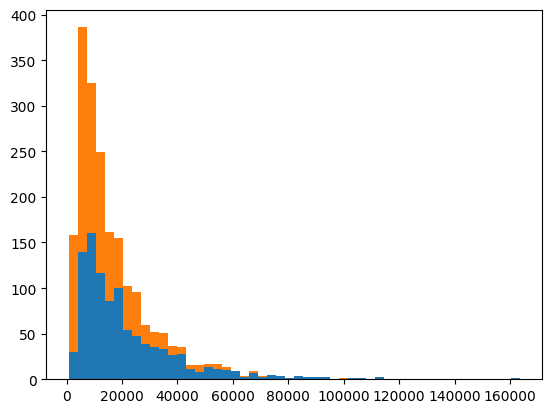

In [9]:
plt.hist([raw_text_n_chars, text_n_chars], 50, stacked= True)
plt.show()

## Shorten texts

In [10]:
def shorten_texts(corpus: list, max_chars: int = 10_000):
    return [text[:max_chars] for text in corpus]

corpus = shorten_texts(corpus)

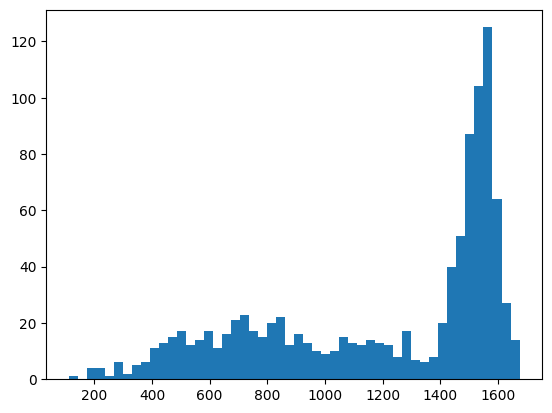

In [11]:
plt.hist([len(text.split()) for text in corpus], 50)
plt.show()

## TF-IDF

In [14]:
N_TFIDF_FEATURES = 200
N_GRAM_ANALYZER = 'word' # ‘word’, ‘char’, ‘char_wb’

vectorizer = TfidfVectorizer(max_features = N_TFIDF_FEATURES, analyzer= N_GRAM_ANALYZER, strip_accents = 'unicode')
X = vectorizer.fit_transform(corpus)
print(X.shape)

(1000, 200)


In [ ]:
tfidf = TFIDF(N_TFIDF_FEATURES)
X = tfidf.vectorize(corpus)

## Clustering | Kmeans

[2 9 7 2 0 4 1 1 4 4 4 1 1 4 4 1 1 1 2 6 8 6 6 2 1 9 1 0 4 4 5 3 3 3 3 8 7
 7 4 0]


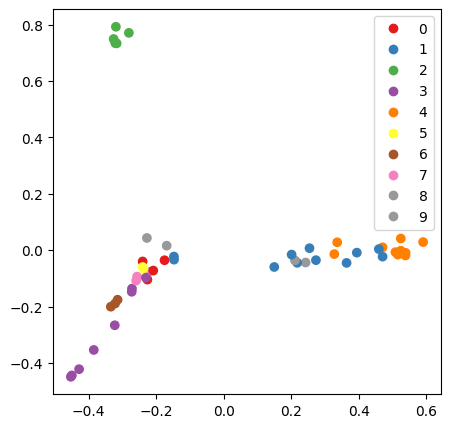

In [28]:
N_KMEANS_CLUSTERS = 10

kmeans = KMeans(n_clusters = N_KMEANS_CLUSTERS, random_state = 0, n_init = "auto").fit(X)
labels = kmeans.labels_
centers = kmeans.cluster_centers_
print(labels[:40])
pca(X, labels)

## Clustering | DBSCAN

{1, 2, 3, -1}
550.3938900149329


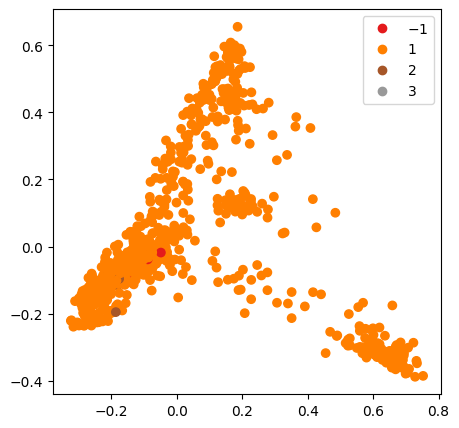

In [226]:
a = X.todense().tolist()
labels = dbscan(a, eps = .05, min_neighbours = 2, dist_function = "eucliean")
print(set(labels))
pca(X, labels)

550.3938900149329


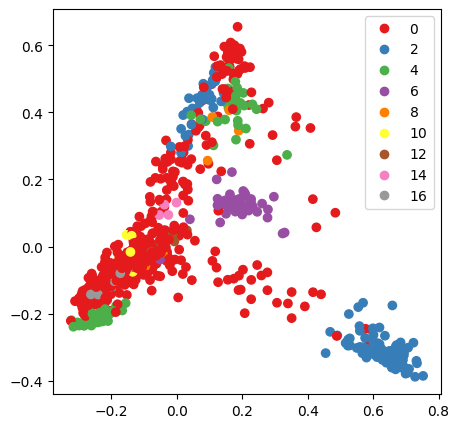

In [232]:
clustering = DBSCAN(eps=.65, min_samples=4).fit(X)
labels = clustering.labels_
pca(X, labels)

In [183]:
for i, (text, label) in enumerate(zip(raw_corpus, labels)):
    if label == 7:
        print(text[:200])
        print(" ")

"Ain't It Fun" is a song by American rock band Paramore, released as the fourth and final single from their self-titled fourth studio album Paramore (2013). Produced by musician Justin Meldal-Johnsen,
 
Herne Bay  is a seaside town in Kent, South East England, with a population of 38,563. On the south coast of the Thames Estuary, it is  north of Canterbury and  east of Whitstable. It neighbours the a
 
Ray Lindwall was a key member of Donald Bradman's famous Australian cricket team, which toured England in 1948. The Australians went undefeated in their 34 matches; this unprecedented feat by a Test s
 
